In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from nb_002 import *

In [3]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'cifar10_dog_air'
TRAIN_PATH = PATH/'train'

In [4]:
default_device = torch.device('cuda', 0)

# Initial model

In [5]:
# NB: validation or training may not have all classes
classes = [cls.name for cls in find_classes(PATH/'train')]

train_ds = FilesDataset(PATH/'train', classes)
valid_ds = FilesDataset(PATH/'test', classes)

In [6]:
len(train_ds), len(valid_ds)

(10000, 2000)

In [9]:
data_mean,data_std = get_batch_stats(data.train_dl)
data_mean,data_std

(tensor([0.5385, 0.5307, 0.5206], device='cuda:0'),
 tensor([0.2537, 0.2610, 0.2826], device='cuda:0'))

In [10]:
cifar_transforms = [
    partial(normalize, data_mean, data_std)
]

cifar_xy_transforms = xy_transforms(cifar_transforms)

In [11]:
data = DataBunch(train_ds, valid_ds, bs=bs, train_tfms=cifar_xy_transforms, valid_tfms=cifar_xy_transforms)
len(data.train_dl), len(data.valid_dl)

(157, 16)

# Data augmentation

## Adding more advanced transformations

Create a Transform class that will have an attribute tfm_type: it can affine, applied to coordinates or applied to the batch of images directly. Grouping the transforms by type when applying them will be more efficient (only one affine multiplication, only one interpolation).

In [26]:
from enum import IntEnum

class TfmType(IntEnum):
    AFFINE = 1
    COORDS = 2
    PIXEL = 3

In [29]:
class Transform():
    
    def __init__(self, tfm_type, func=None):
        if func is None: func = noop
        self.tfm_type, self.func = tfm_type, func
    
    def __call__(self, x):
        return self.func(x)

Helper function that does an affine transformation.

In [30]:
def do_affine(x, matrix, interpol = True, padding='reflect'):
    """
    Applies an affine transformation to a batch of images.
    
    Optional: only computes the new coordinates without doing the interpolation to create the new images.
    Args:
    x: a batch of images
    matrix: a matrix of size 2 by 3 describing the transformation.
            if the transformation is Ax + b, the matrix is (A|b)
    interpol: if False, returns only the new coordinates
    padding: padding to apply during the interpolation. Supports zeros, border, reflect
    
    """
    coords = F.affine_grid(matrix[None].expand(x.size(0), 2, 3), x.size())
    return interpolate(x,coords,padding) if interpol else coords

In [58]:
def interpolate(x, coords, padding='reflect'):
    if padding=='reflect':#Reflect padding isn't implemented in grid_sample yet
        coords[coords < -1] = coords[coords < -1].mul_(-1).add_(-2)
        coords[coords > 1] = coords[coords > 1].mul_(-1).add_(2)
        padding='zeros'
    return F.grid_sample(x, coords, padding_mode=padding)

Creating an affine transform is done by giving the matrix of the transformation.

In [67]:
class RandomRotate(Transform):
    
    def __init__(self, degrees, p=0.75):
        super().__init__(TfmType.AFFINE)
        self.degrees, self.p = degrees, p
        
    def __call__(self, x):
        matrix = self.get_matrix(x)[:2,:]
        return do_affine(x, matrix)
        
    def get_matrix(self, x):
        device = x.device if hasattr(x,'device') else default_device
        angle = np.random.uniform(-self.degrees, self.degrees) * math.pi / 180
        return torch.tensor([[math.cos(angle), -math.sin(angle), 0],
                             [math.sin(angle),  math.cos(angle), 0],
                             [0,                0,               1]], device=device) 

In [88]:
def denorm(x):
    x = x.permute([0,2,3,1])
    return x * data_std + data_mean

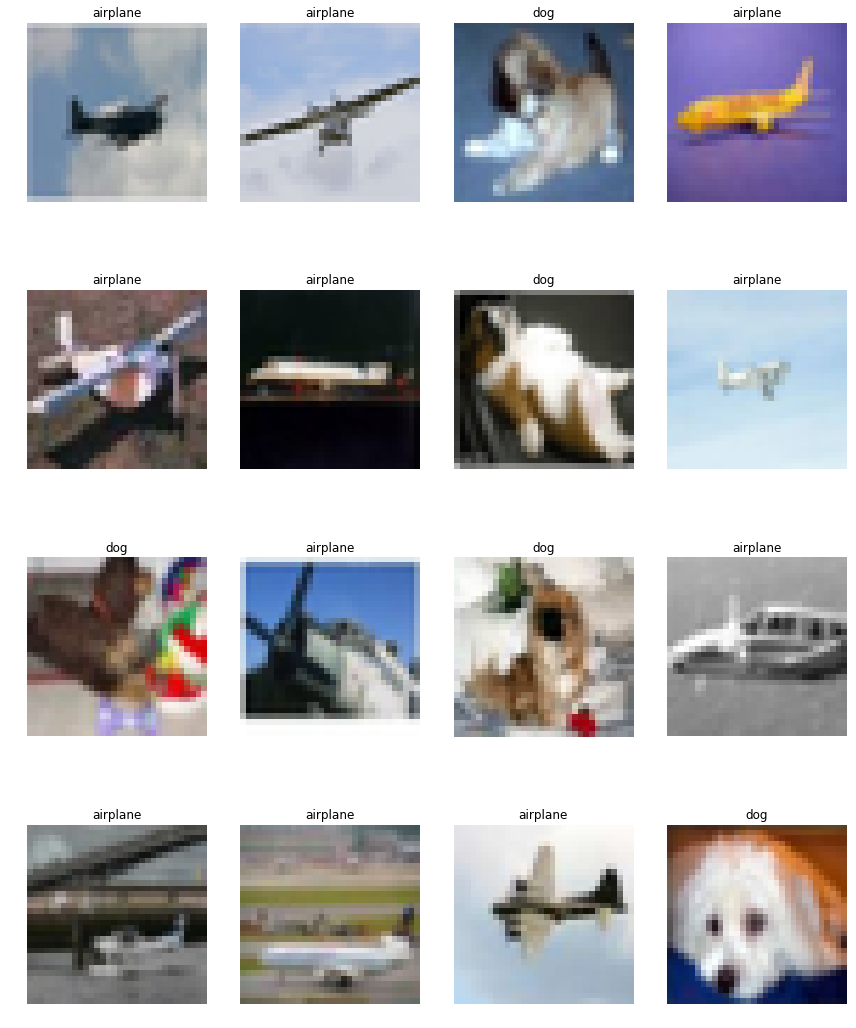

In [106]:
x,y = next(iter(data2.train_dl))[:16]
img = denorm(x)
show_images(img,y,4, classes)

In [ ]:
x1 = RandomRotate(30)(x)
img = denorm(x1)

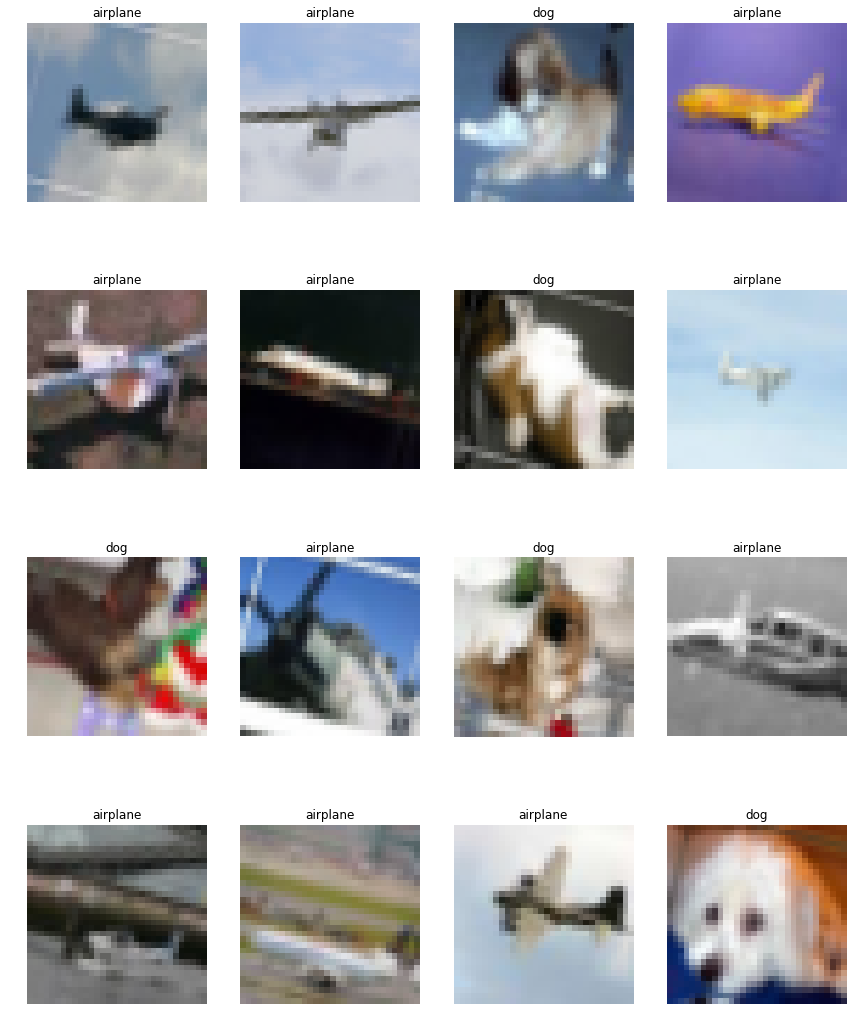

In [107]:
show_images(img,y,4, classes)

Zooming is antoher type of affine transformation.

In [108]:
class RandomZoom(Transform):
    
    def __init__(self, zoom_max, zoom_min=0):
        super().__init__(TfmType.AFFINE)
        self.zoom_range = (zoom_min, zoom_max)
        
    def __call__(self, x):
        matrix = self.get_matrix(x)[:2]
        return do_affine(x, matrix)
        
    def get_matrix(self, x):
        device = x.device if hasattr(x,'device') else default_device
        zoom = np.random.uniform(*self.zoom_range)
        return torch.tensor([[zoom, 0,    0],
                             [0,    zoom, 0],
                             [0,    0,    1]], device=device) 

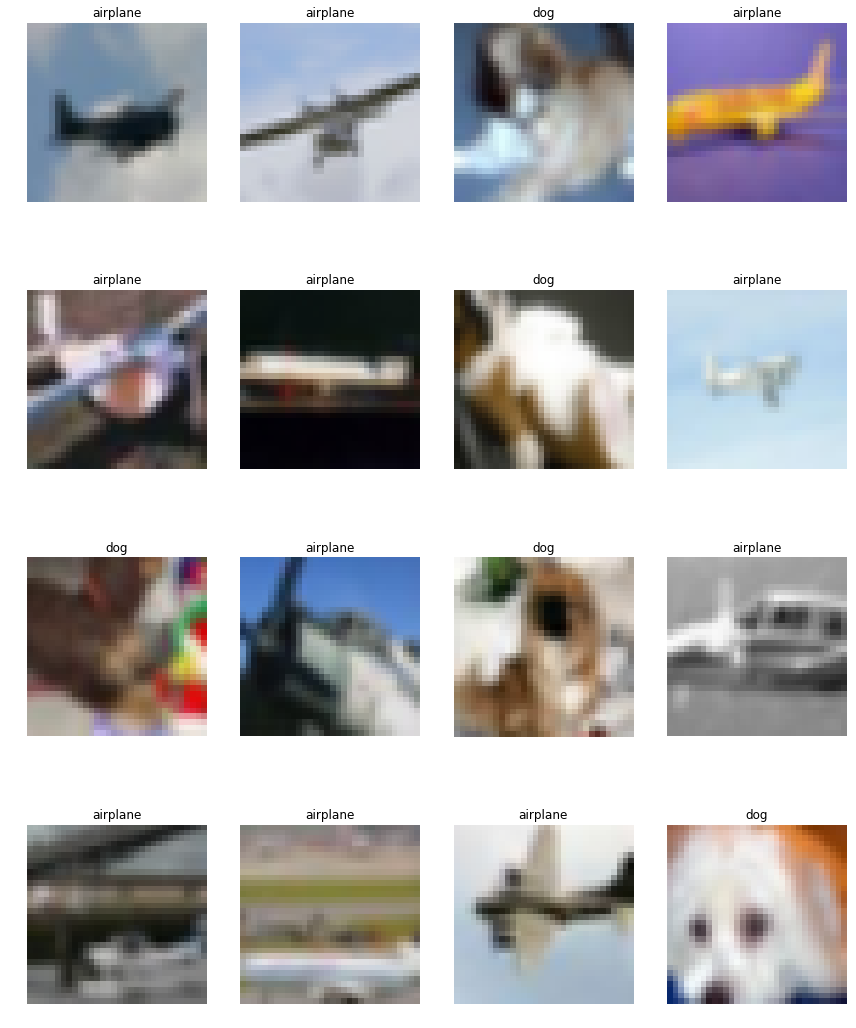

In [109]:
x1 = RandomZoom(1,0.5)(x)
img = denorm(x1)
show_images(img,y,4, classes)

A coord transform is done by creating the function that changes the coordinates. Here we randomly move the pixels.

In [120]:
def get_coords(x):
    matrix = torch.tensor([[1., 0., 0.], [0., 1., 0.]], device=x.device)
    return F.affine_grid(matrix[None].expand(x.size(0), 2, 3), x.size())

In [126]:
class RandomJitter(Transform):
    
    def __init__(self, magnitude):
        super().__init__(TfmType.COORDS)
        self.magnitude = magnitude
        
    def __call__(self, x):
        coords = get_coords(x)
        coords = self.tfm_coord(coords)
        return interpolate(x, coords)
        
    def tfm_coord(self, coords):
        noise = torch.from_numpy(np.random.uniform(-self.magnitude, self.magnitude, coords.size()).astype(np.float32)).to(coords.device)
        return coords.add_(noise)

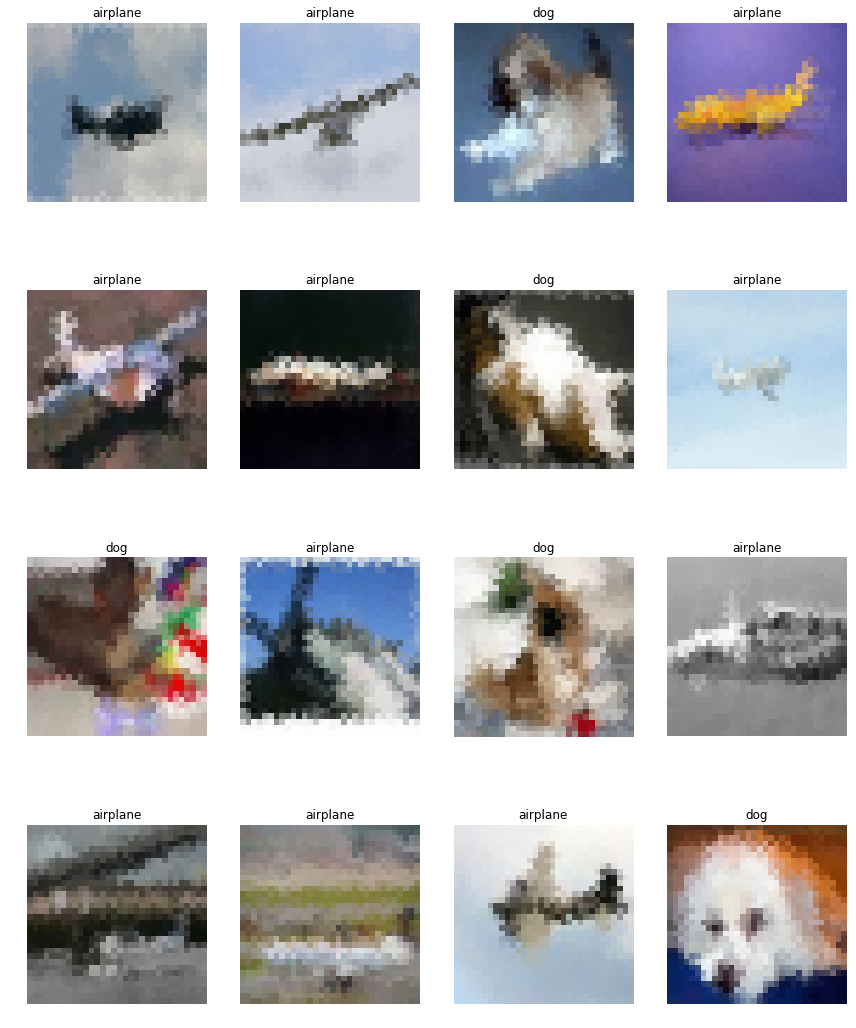

In [128]:
x1 = RandomJitter(0.05)(x)
img = denorm(x1)
show_images(img,y,4, classes)

## Compose the transforms

In [133]:
def compose_tfms(tfms, x):
    i, first_tfms = 0, []
    #First applies the global transforms at the beginning
    while i < len(tfms) and tfms[i].tfm_type == TfmType.PIXEL: i+=1
    first_tfms = tfms[:i]
    x = compose(first_tfms)(x)
    if i >= len(tfms): return x
    
    #Then we group in the following order: affines, coords, pixels
    affine_tfms = [tfm for tfm in tfms[i:] if tfm.tfm_type == TfmType.AFFINE]
    coord_tfms = [tfm for tfm in tfms[i:] if tfm.tfm_type == TfmType.COORDS]
    last_tfms = [tfm for tfm in tfms[i:] if tfm.tfm_type == TfmType.PIXEL]
    
    #Starting with the identity matrix, we multiply all the affine matrices before applying one affine transformation
    matrix = torch.eye(3, device=x.device)
    for tfm in affine_tfms: matrix = matrix.mm(tfm.get_matrix(x))
    matrix = matrix[:2,:]
    coords = F.affine_grid(matrix[None].expand(x.size(0), 2, 3), x.size())
    
    #Then we apply all the transformations on the coordinates before doing one interpolation
    for tfm in coord_tfms: coords = tfm.tfm_coord(coords)
    x = interpolate(x, coords)
    
    #Lastly, we apply the remaining pixel transforms
    return compose(last_tfms)(x)

In [147]:
Channel_first = Transform(TfmType.PIXEL, channel_first)
Normalize = Transform(TfmType.PIXEL, partial(normalize, data_mean[None,:,None,None], data_std[None,:,None,None]))

In [159]:
def denorm(x):
    x = x.permute([0,2,3,1])
    return x *  data_std[None,None,None,:] + data_mean[None,None,None,:]

In [154]:
tfms = [Channel_first, RandomRotate(10), RandomZoom(1.1,0.9), RandomJitter(0.05), Normalize]

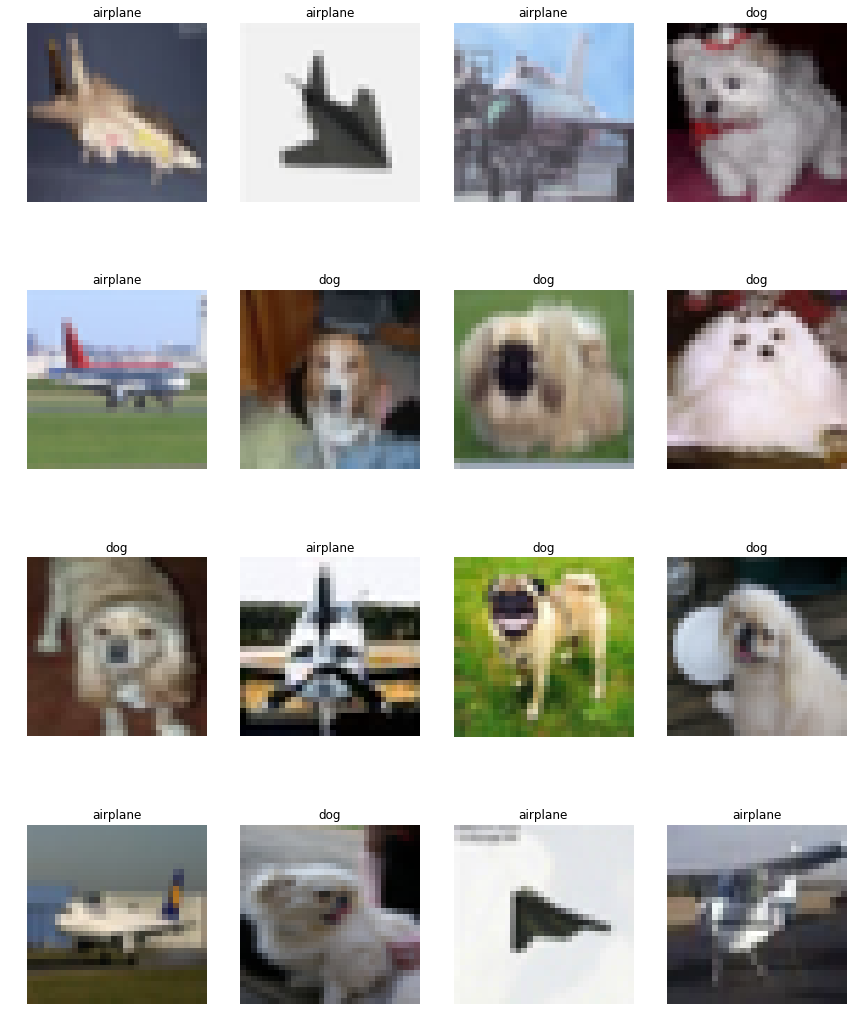

In [163]:
x,y = next(iter(data.train_dl))
show_images(x,y,4, classes)

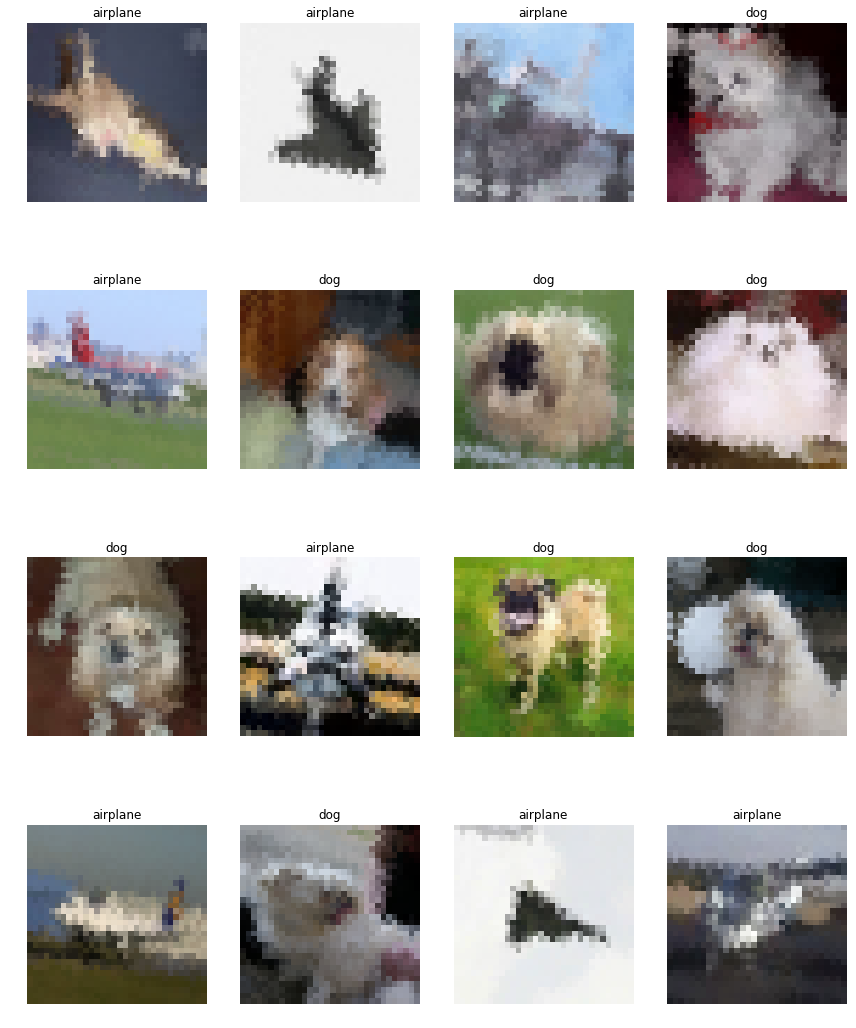

In [164]:
x1 = compose_tfms(tfms,x)
img = denorm(x1)
show_images(img,y,4, classes)